In [1]:
from __future__ import print_function, division

import os
import pandas as pd
from PIL import Image

import numpy as np
from glob import glob

import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from ipywidgets import IntProgress

In [2]:
train_dir = '/opt/ml/input/data/train/images'
log_dir = '/opt/ml/code'

In [3]:
from torchvision.models import resnet18, resnet50, resnet101, detection
from torch.optim import Adam, SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import StratifiedKFold

In [4]:
# Misc

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [5]:
# Dataset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import os
import cv2
import numpy as np
from glob import glob

class MaskDataset(Dataset):
  def __init__(self, data_root, is_Train=True, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list, self.labels= self._load_img_list(data_root, is_Train)
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
    # Image Loading
    img = Image.open(img_path)

    if self.transform:
      img = self.transform(img)

    # Ground Truth
    label = self._get_class_idx_from_img_name(img_path)
    return img, label

  def __len__(self):
    return self.len

  def _load_img_list(self, data_root, is_Train):
    # Change the name of directory which has inconsistent naming rule.
    full_img_list = glob(data_root + '/*')

    for dir in full_img_list:
      dirname = os.path.basename(dir)
      if '-' in dirname:
        shutil.move(dir, dir.replace(dirname, dirname.replace('-', '')))
    
    img_list = []
    labels = []
    for dir in glob(data_root + '/*'):
      label = []
      img_list.extend(glob(dir+'/*'))
      for path in glob(dir+'/*'):
          label.append(self._get_class_idx_from_img_name(path))
      labels.extend(label)
    return img_list, labels

  def _load_img_ID(self, img_path):
    return int(os.path.basename(img_path).split('_')[0])

  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path)
    dir = img_path.split('/')
    img_info = dir[-2]
    
    label = [[[0,1,2],[3,4,5]],[[6,7,8], [9,10,11]],[[12,13,14],[15,16,17]]]
    if 'normal' in img_name:
        msk = 2
    elif 'incorrect_mask' in img_name:
        msk = 1
    elif 'mask' in img_name :
        msk = 0
    
    if 'female' in img_info:
        gdr = 1
    elif 'male' in img_info:
        gdr = 0
    
    if int(img_info[-2:]) < 30:
        age = 0
    elif 30 <= int(img_info[-2:]) < 60:
        age = 1
    elif 60 <= int(img_info[-2:]):
        age = 2

    return label[msk][gdr][age]
    

In [6]:
data_root = '/opt/ml/input/data/train/images'
input_size = 224
batch_size = 32
lr = 1e-04
EPOCHS=10

# Dataset and Data Loader
train_transform = transforms.Compose([
    transforms.RandomCrop((330,220)),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize([0.560, 0.524, 0.501], [0.233, 0.243, 0.246])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.560, 0.524, 0.501], [0.233, 0.243, 0.246])
])

dataset = MaskDataset(data_root, is_Train=True, input_size=input_size, transform=train_transform)
labels = dataset.labels


In [7]:
device = torch.device('cuda')

'''======================== TO DO Setting ========================'''
pretrained = True # True of False
'''==============================================================='''

model = resnet50(pretrained)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 18)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-04)

In [8]:
from sklearn.model_selection import KFold

k_folds = 5
skfold = StratifiedKFold(n_splits=k_folds, shuffle=True)

/opt/ml/input/data/train/images/004289_male_Asian_60/mask5.jpg


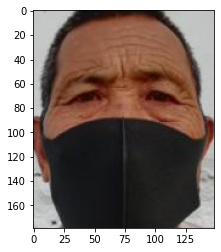

(38 ~ 43)


In [9]:
import mtcnn
from mtcnn.mtcnn import MTCNN

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

def imgDetector(img_path,cascade,age_net,MODEL_MEAN_VALUES,age_list):    
    image = Image.open(img_path)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    
    x1, y1, w, h = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + w, y1 + h
    face = pixels[y1-10:y2+10, x1-10:x2+10]
    blob = cv2.dnn.blobFromImage(face, 1, (227, 227), [104, 117, 123], True, False)

    age_net.setInput(blob)
    age_preds = age_net.forward()
    age = age_preds.argmax()
    info = age_list[age]
    image = Image.fromarray(face)
    face_array = np.asarray(image)
    plt.imshow(face_array)
    plt.show()
    print(info)

cascade_filename = 'haarcascade_frontalface_alt.xml'
cascade = cv2.CascadeClassifier(cascade_filename)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

age_net = cv2.dnn.readNetFromCaffe('deploy_age.prototxt','age_net.caffemodel')
age_list = ['(0 ~ 2)','(4 ~ 6)','(8 ~ 12)','(15 ~ 20)', '(25 ~ 32)','(38 ~ 43)','(48 ~ 53)','(60 ~ 100)']

print(dataset.img_list[9000])
info = imgDetector(dataset.img_list[9000],cascade,age_net,MODEL_MEAN_VALUES,age_list)

In [10]:
# Main
print("Progress ...", end="", flush=True)
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'train_log.csv'), 'w') as log:
    for fold, (train_ids, valid_ids) in enumerate(skfold.split(dataset, labels)):                                                 
        best_accuracy = 0
        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_subsampler)
        
        model = resnet101(pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 18)

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=1e-04)
        
        for epoch in range(EPOCHS):
            train_loss, valid_loss = AverageMeter(), AverageMeter()

            correct = 0
            total = 0
            acc_train = 0
            # Training
            model.train()
            for iter, (img, hm_gt) in enumerate(train_loader):
              '''================================================================'''
              '''======================== TO DO Main (1) ========================'''
              # optimizer에 저장된 미분값을 0으로 초기화
              optimizer.zero_grad()
              # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
              img, hm_gt = img.cuda(), hm_gt.cuda()
              
              # 모델에 이미지 forward
              pred_logit = model(img)
              # loss 값 계산
              loss = 0
              loss = criterion(pred_logit, hm_gt)

              _, predicted = torch.max(pred_logit.data, 1)
              correct += (predicted == hm_gt).sum().item()
              total += img.size(0)
              # Backpropagation
              loss.backward()
              optimizer.step()
              '''======================== TO DO Main (1) ========================'''
              '''================================================================'''

              # Log Update
              train_loss.update(loss.item(), len(img))
              print("\rEpoch [%3d/%3d] | Iter [%3d/%3d] | Train Loss %.4f" % (epoch+1, EPOCHS, iter+1, len(train_loader), train_loss.avg), end= '')
            
            acc_train = 100*(correct/total)
            print(" Accuracy %.2f" % (acc_train))
            # Validation
            test_loss = 0
            total = 0
            correct = 0
            accr_val = 0


            model.eval()
            for iter, (img, hm_gt) in enumerate(valid_loader):
              '''================================================================'''
              '''======================== TO DO Main (2) ========================'''
              # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
              img, hm_gt = img.cuda(), hm_gt.cuda()

              # 모델에 이미지 forward (gradient 계산 X)
              with torch.no_grad():
                pred_logit = model(img)

              _, predicted = torch.max(pred_logit.data,1)
              correct += (predicted == hm_gt).sum().item()
              total += img.size(0)

              # loss 값 계산
              loss = 0
              loss = criterion(pred_logit, hm_gt)
              '''======================== TO DO Main (2) ========================'''
              '''================================================================'''

            # Log Update
            valid_loss.update(loss.item(), len(img))
            accr_val = (100* correct / total)
            print("Epoch [%3d/%3d] | Valid Loss %.4f | Accuracy : %.2f" % (epoch+1, EPOCHS, valid_loss.avg, accr_val))

            # Log Writing
            log.write('%d,%.4f,%.4f\n'%(epoch, train_loss.avg, valid_loss.avg))
            if accr_val > best_accuracy:
                best_accuracy = accr_val
                if not os.path.exists(log_dir):
                    os.mkdir(log_dir)
                print(f"Model saved : acc - {accr_val}")

                torch.save(model, f'{log_dir}/model{fold}.pt')  
                torch.save(model.state_dict(), 
                           f'{log_dir}/model_state_dict{fold}.pt')  
                torch.save({
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()
                    }, f'{log_dir}/all{fold}.tar')

print("Done")

Epoch [  1/ 10] | Iter [473/473] | Train Loss 0.4756 Accuracy 85.58
Epoch [  1/ 10] | Valid Loss 1.1671 | Accuracy : 85.58
Model saved : acc - 85.58201058201058
Epoch [  2/ 10] | Iter [473/473] | Train Loss 0.2191 Accuracy 92.74
Epoch [  2/ 10] | Valid Loss 0.8449 | Accuracy : 93.54
Model saved : acc - 93.54497354497354
Epoch [  3/ 10] | Iter [473/473] | Train Loss 0.1378 Accuracy 95.50
Epoch [  3/ 10] | Valid Loss 0.2520 | Accuracy : 96.27
Model saved : acc - 96.26984126984127
Epoch [  4/ 10] | Iter [ 47/473] | Train Loss 0.1052

KeyboardInterrupt: 

In [11]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [12]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [14]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.560, 0.524, 0.501], [0.233, 0.243, 0.246])
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

device = torch.device('cuda')
oof_pred = None
for idx in range(5):
    model = torch.load(f'{log_dir}/model{idx}.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
    model.load_state_dict(torch.load(f'{log_dir}/model_state_dict{idx}.pt'))  # state_dict를 불러 온 후, 모델에 저장

    checkpoint = torch.load(f'{log_dir}/all{idx}.tar')   # dict 불러오기
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    model.eval()

    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    predictions = [0]*18
    for images in loader:
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    fold_pred = np.array(all_predictions)
    print(fold_pred)
    if oof_pred is None:
        oof_pred = fold_pred / 5
    else :
        oof_pred += fold_pred / 5
    
submission['ans'] = np.argmax(oof_pred, axis=1)
# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

[13  2 13 ...  9  1  8]


KeyboardInterrupt: 